# Customer Segmentation, Matrix Decomposition, PCA, SVD, Clustering

In [41]:
import pandas as pd
import numpy as np

In [42]:
train = pd.read_csv('order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [43]:
products = pd.read_csv('products.csv')
products.head()

,Unnamed: 0,product_id,product_name,aisle_id,department_id,aisle,department,item_is_Organic,item_is_Gluten-Free,item_is_Asian
0,0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,0,0,0
1,1,2,All-Seasons Salt,104,13,spices seasonings,pantry,0,0,0
2,2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,0,0,0
3,3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,0,0,0
4,4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,0,0,0


In [44]:
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [45]:
prior = pd.read_csv('order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0


In [46]:
prior = prior[prior.reordered == 1]
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
3,2,45918.0,4.0,1.0
5,2,17794.0,6.0,1.0
6,2,40141.0,7.0,1.0


In [47]:
prior = prior.merge(orders[['order_id', 'user_id']])
prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id
0,2,33120.0,1.0,1.0,202279
1,2,28985.0,2.0,1.0,202279
2,2,45918.0,4.0,1.0,202279
3,2,17794.0,6.0,1.0,202279
4,2,40141.0,7.0,1.0,202279


In [50]:
prior.shape

(5123707, 5)

### Reducing data for faster results

In [51]:
prior = prior.head(20000)

In [52]:
prior.product_id = pd.to_numeric(prior.product_id, downcast='integer')
prior.product_id = prior.product_id.astype(str)

In [53]:
prior_usr_prod = prior.groupby('user_id').apply(lambda x: x.product_id.tolist())
prior_usr_prod.head()

user_id
90     [32818, 27582, 12302, 1831, 19204, 10180, 1545...
150    [17616, 16953, 49615, 42972, 24600, 18811, 612...
206                                 [13176, 5612, 47209]
208                         [45223, 21137, 24333, 27872]
382                         [10070, 42450, 33198, 34866]
dtype: object

In [54]:
prior_usr_prod = prior_usr_prod.reset_index()
prior_usr_prod.columns = ['user_id','product_set']
prior_usr_prod.product_set = prior_usr_prod.product_set.astype(str)
prior_usr_prod.head()

,user_id,product_set
0,90,"['32818', '27582', '12302', '1831', '19204', '..."
1,150,"['17616', '16953', '49615', '42972', '24600', ..."
2,206,"['13176', '5612', '47209']"
3,208,"['45223', '21137', '24333', '27872']"
4,382,"['10070', '42450', '33198', '34866']"


In [55]:
del train, products, orders, prior
import gc
gc.collect()

157

# Dimensionality Reduction

#### Firstly we create sparse matrix for user-product using TF-IDF

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

In [57]:
tfidf = TfidfVectorizer(min_df=5, lowercase=False)
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [58]:
tfidf.fit(prior_usr_prod.product_set)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [59]:
prod_tfidf = tfidf.transform(prior_usr_prod['product_set'])
prod_tfidf

<2872x813 sparse matrix of type '<class 'numpy.float64'>'
	with 11661 stored elements in Compressed Sparse Row format>

## SVD

SVD with 2 components just to get the gist of the data. The singular value decomposition is a factorization. It takes in rectangular matrices, and gives some guarantees with the resulting three matrix result. We usually write it as A = U(Sigma)V^t.
SVD is the analogue of the eigenvalue decomposition for general m×n matricies (rather than a strictly square n×n one in the eignvalue case)

In [60]:
svd = TruncatedSVD(n_components=2)
svd_user = svd.fit_transform(prod_tfidf)
svd_user = pd.DataFrame(svd_user)
svd_user.columns = ['pf_0','pf_1']
svd_user['user_id'] = prior_usr_prod.user_id
svd_user.head()

,pf_0,pf_1,user_id
0,0.004819,0.000424,90
1,0.021621,-0.006465,150
2,0.191177,0.358692,206
3,0.181698,0.115976,208
4,0.024071,0.005877,382


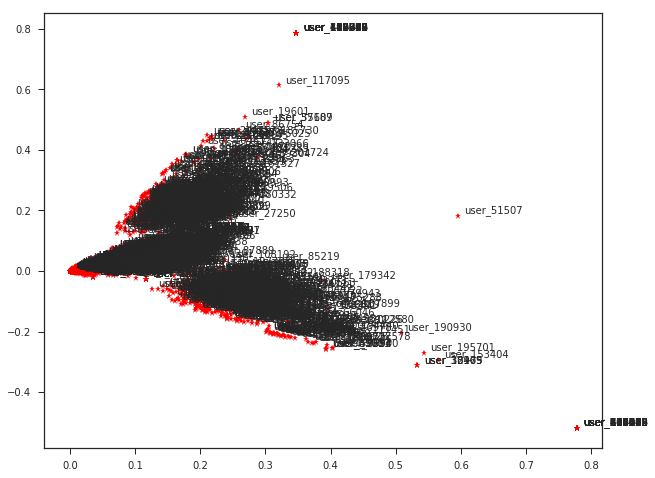

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(svd_user['pf_0'],svd_user['pf_1'],'r*',label=svd_user['user_id'])
for row in svd_user.itertuples():
    plt.annotate('user_'+str(row.user_id), xy=(row.pf_0,row.pf_1), 
            xytext=(row.pf_0+0.01,row.pf_1+0.01)
            )

We can see 3 major clusters in this figure.

### Non-Negative Matrix Factorization

Non Negative Matrix Factorization is similar to SVD. SVD factors contains both positive and negative entries while NMF factors are strictly positive. This is useful in case of text mining where usually TF or TF-IDF matrix is being factorized. Since entries of original matrix are positive and has physical meaning (term frequencies...), once would want factors to be positive so that physical connections are be directly made.
Non-negative matrix factorization is for an m×n matrix with non-negative entries.  Roughly speaking, it is about finding an m×k and a k×n matrix (all with positive entries) whose product is your matrix of interest

In [62]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [63]:
nmf = NMF(n_components = 50, random_state = 42)
model = nmf.fit(prod_tfidf)
H = model.components_
model.components_.shape

(50, 813)

In [64]:
W = model.transform(prod_tfidf)

In [65]:
user_data = pd.DataFrame(normalize(W), index = prior_usr_prod['user_id'])
user_data.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
user_id,,,,,,,,,,,,,,,,,,,,,
90,0.066492,0.042005,0.0,0.0,0.0,0.051423,0.000000,0.00000,0.0,0.245654,...,0.017548,0.0,0.137802,0.0,0.0,0.007905,0.43817,0.424072,0.000000,0.0
150,0.005727,0.000000,0.0,0.0,0.0,0.000000,0.013638,0.00000,0.0,0.000000,...,0.041917,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.011403,0.0
206,0.001485,0.561981,0.0,0.0,0.0,0.000000,0.000000,0.82628,0.0,0.001954,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0
208,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0
382,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.450519,0.0


I could pick a random user and find users that have similar purchasing behavior. Similarity is calculated using dot product with other users

In [66]:
# For user_id 1
print('User_id: ==>', user_data.index[0])
idx = user_data.dot(user_data.iloc[0]).nlargest(5).index
user_data.dot(user_data.iloc[0]).nlargest(5)

User_id: ==> 90


user_id
90        1.000000
87601     0.716088
135521    0.663391
86142     0.656993
63979     0.647534
dtype: float64

In [67]:
# For user_id 1
print('User_id: ==>', user_data.index[10])
idx = user_data.dot(user_data.iloc[10]).nlargest(5).index
user_data.dot(user_data.iloc[10]).nlargest(5)

User_id: ==> 971


user_id
971       1.0
29697     1.0
172134    1.0
194166    1.0
201183    1.0
dtype: float64

## Using PCA

PCA needs data to be dense so we need to convert sparse matrix to dense

In [68]:
prod_matrix = prod_tfidf.toarray()

In [69]:
prod_matrix.shape

(2872, 813)

In [70]:
import sys

In [71]:
sys.getsizeof(prod_matrix)/1024**3

0.017396733164787292

In [73]:
pca = PCA(n_components=813)

In [74]:
pca.fit(prod_matrix)

PCA(copy=True, iterated_power='auto', n_components=813, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [75]:
np.sum(pca.explained_variance_ratio_)*100

100.0

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline

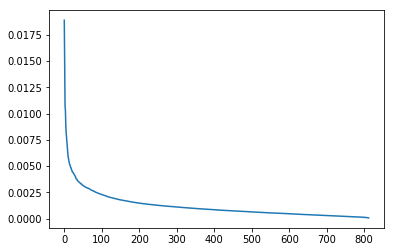

In [77]:
plt.plot(pca.explained_variance_ratio_)

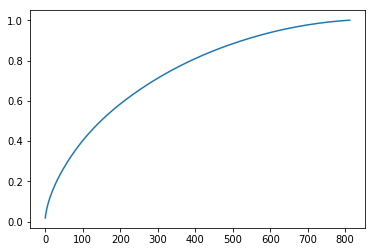

In [78]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [80]:
for i in [1, 2, 10, 100, 200, 300, 400, 500, 600, 700, 813]:
    print('Variance Explained with {0:} vectors: {1:.2f}'.format(i, np.sum(pca.explained_variance_ratio_[0:i])*100))

Variance Explained with 1 vectors: 1.89
Variance Explained with 2 vectors: 3.38
Variance Explained with 10 vectors: 10.01
Variance Explained with 100 vectors: 40.06
Variance Explained with 200 vectors: 58.30
Variance Explained with 300 vectors: 71.12
Variance Explained with 400 vectors: 80.88
Variance Explained with 500 vectors: 88.30
Variance Explained with 600 vectors: 93.85
Variance Explained with 700 vectors: 97.67
Variance Explained with 813 vectors: 100.00


Nearly half of the components explain 80% of the data so we reduce the dimension from 813 to 400

In [85]:
pca = PCA(n_components=400)
prod_matrix_400 = pca.fit_transform(prod_matrix)
prod_matrix_400.shape

(2872, 400)

In [86]:
prod_matrix_400

array([[-0.0170075 , -0.05267836, -0.03660151, ..., -0.01647539,
        -0.03500282, -0.0096486 ],
       [-0.00407208, -0.0512683 , -0.04349557, ...,  0.02872019,
        -0.01902206, -0.00435293],
       [-0.21277875,  0.31322732,  0.00537641, ..., -0.02069333,
         0.05445652,  0.02569709],
       ..., 
       [-0.03645746, -0.06343908,  0.24737347, ..., -0.04039785,
        -0.01319954,  0.02545873],
       [ 0.01529382, -0.05177242, -0.03622234, ...,  0.011685  ,
         0.00537994,  0.01628919],
       [-0.02354333, -0.04881882, -0.03077755, ..., -0.02391572,
         0.00705012, -0.01942057]])

### KMeans Clustering

We use K-Means clustering on the reduced dimension data to segment the customers/users together

In [87]:
prod_df = pd.DataFrame(prod_matrix_400)
prod_df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.017007,-0.052678,-0.036602,-0.015030,-0.020916,-0.019857,0.007806,-0.026679,-0.007489,-0.003414,...,-0.055893,-0.030635,-0.006849,-0.038694,-0.005546,0.001433,-0.035860,-0.016475,-0.035003,-0.009649
1,-0.004072,-0.051268,-0.043496,-0.018382,-0.026249,-0.016688,0.015821,-0.030672,-0.016647,-0.019632,...,0.033546,0.000098,0.083126,0.028549,0.042311,-0.005410,0.040769,0.028720,-0.019022,-0.004353
2,-0.212779,0.313227,0.005376,0.018332,-0.026127,-0.105365,-0.053801,0.275669,-0.111775,0.079792,...,0.059869,0.022419,-0.057040,-0.054422,-0.042479,-0.032312,-0.003025,-0.020693,0.054457,0.025697
3,-0.041869,-0.040456,0.318879,0.848390,0.202827,-0.014142,0.031430,-0.198696,-0.003171,-0.082030,...,-0.003744,-0.008435,-0.005944,-0.003046,-0.001042,-0.008543,-0.000173,-0.006564,-0.002185,-0.000591
4,-0.017674,-0.066071,-0.032255,-0.023844,-0.035117,-0.019244,0.013971,-0.046422,-0.026723,0.013650,...,0.012675,-0.009857,-0.000747,0.009743,-0.005876,0.009307,0.003162,-0.011946,-0.015599,-0.002947


Plotting first 2 components of the matrix

(2872, 2)
          1         0
0 -0.052678 -0.017007
1 -0.051268 -0.004072
2  0.313227 -0.212779
3 -0.040456 -0.041869
4 -0.066071 -0.017674


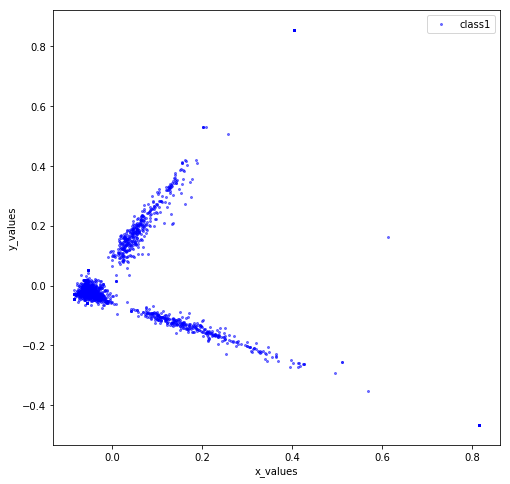

In [91]:
from matplotlib import pyplot as plt

tocluster = pd.DataFrame(prod_df[[1,0]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[1], tocluster[0], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [92]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Creating 3 clusters as seen earlier

In [96]:
clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.04782745 -0.01847061]
 [ 0.09291656  0.25801608]
 [ 0.23455591 -0.16760903]]


In [97]:
print (c_preds[0:100])

[0 0 2 0 0 1 0 1 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 1
 0 0 0 0 0 0 2 0 2 0 0 1 0 0 2 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 2 0 0 0 0 1 0
 0 1 0 0 2 1 0 0 0 2 0 0 2 0 0 1 0 0 0 2 0 0 0 0 2 0]


['orange', 'orange', 'purple', 'orange', 'orange', 'blue', 'orange', 'blue', 'orange', 'orange']


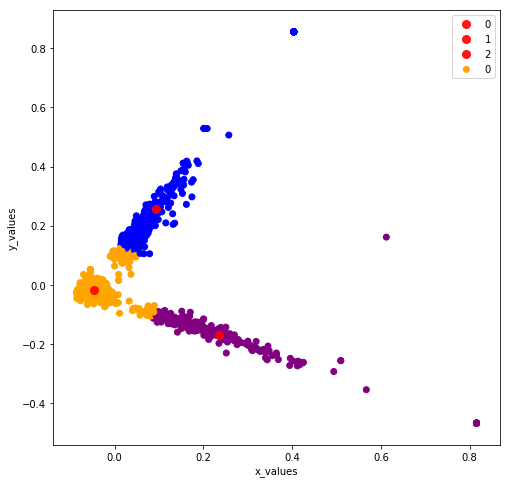

In [98]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[0],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [101]:
# These are the users that are clustered together
clust_user = svd_user.copy()
clust_user['cluster'] = c_preds
clust_user.head(10)

,pf_0,pf_1,user_id,cluster
0,4.819263e-03,4.238390e-04,90,0
1,2.162146e-02,-6.464912e-03,150,0
2,1.911773e-01,3.586920e-01,206,2
3,1.816979e-01,1.159755e-01,208,0
4,2.407086e-02,5.877431e-03,382,0
5,4.023484e-01,-2.529410e-01,503,1
6,-3.675198e-19,-8.766367e-19,508,0
7,3.150858e-01,-1.481113e-01,678,1
8,9.249435e-03,1.848799e-03,787,0
9,4.210428e-02,-4.015390e-03,917,0


In [103]:
import seaborn as sns
sns.set(style='ticks')

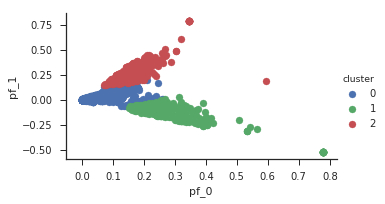

In [110]:
fg = sns.FacetGrid(data=clust_user, hue='cluster', aspect=1.61)
fg.map(plt.scatter, 'pf_0', 'pf_1').add_legend()

We can see that components obtained data factorized using SVD when plotted forms similar clusters as those obtined using PCA 